In [48]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import special
import mpmath as mp
%matplotlib inline

In [49]:
import classy
from classy import Class

In [50]:
LambdaCDM = Class()
# run class
LambdaCDM.compute()
bg = LambdaCDM.get_background()
D_data = bg['gr.fac. D'] #growth factor
f_data = bg['gr.fac. f'] #logarithmic growth rate
H_data = bg['H [1/Mpc]']/LambdaCDM.h() #Hubble factor in units of h/Mpc
z_data = bg['z'] #redshift, off course
comoving_distance_data = bg['comov. dist.']*1000#*LambdaCDM.h() #comoving distance in units of Mpc/h

#now we spline them
from scipy.interpolate import CubicSpline
a_data = 1./(1. + z_data)
D_growth = CubicSpline(a_data , D_data)
f_growth = CubicSpline(a_data , f_data)
Hubble = CubicSpline(a_data , H_data)
comoving_distance = CubicSpline(a_data, comoving_distance_data)

In [51]:
def D_angular(z_i):
    a_i = 1/(1 + z_i)
    return a_i*comoving_distance(a_i)
def D_sl(z_s, z_l):
    a_s = 1/(1 + z_s)
    a_l = 1/(1 + z_l)
    return a_l*(comoving_distance(a_s) - comoving_distance(a_l))

In [52]:
def density(theta, theta_0):
    sigma = 0.3
    return np.exp(-0.5*np.sum((theta - theta_0[:, None, None]*np.ones_like(theta))**2/sigma**2, 0))/(2*np.pi*sigma**2)

In [53]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 0:
            break
      ...

  0%|          | 0/4000 [00:00<?, ?it/s]


In [54]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info[i] = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 4000:
            break
      ...

100%|██████████| 4000/4000 [00:22<00:00, 178.93it/s]


In [55]:
import h5py
data = h5py.File('data/240818_tng50-1_dm_99_gids.1000.2000.hdf5', 'r')

galaxies_data = data['dm']['metadata']
galaxies = data['dm']['images']

N = np.size(galaxies[0, 0, :])
N_min = int(N*0.5 - 50)
N_max = int(N*0.5 + 50)

galaxies = galaxies[:, N_min:N_max, N_min:N_max]

In [56]:
X = np.zeros([4000, N])
X.shape

(4000, 512)

In [57]:
for i in range(0, 4000):
    X[i, :] = np.linspace(info[i]['extent'][0][0], info[i]['extent'][0][1], N)

X = X[:, N_min:N_max]

In [58]:
galaxies.shape

(4000, 100, 100)

In [59]:
#It takes the array on which the bidimensional density is computed, and the bidimensional density itself
def newtonian_potential_grid(theta, Epsilon):
    dtheta = theta[1] - theta[0]
    eps = 0.0001*dtheta #softening length
    integrand = Epsilon[:, :, None, None]*np.log(np.sqrt((theta[:, None, None, None] - theta[None, None, :, None])**2 + (theta[None, :, None, None] - theta[None, None, None, :])**2 + eps**2) )
    result = np.sum(integrand, axis= (0, 1))
    return dtheta*dtheta*(result - np.ones_like(result)*result[0, 0])

In [65]:
GM = 4.302*1e-6
c_light = 2.99792*1e+5

GM_c2 = GM/(c_light*c_light)
GM_c2

4.78663516644209e-17

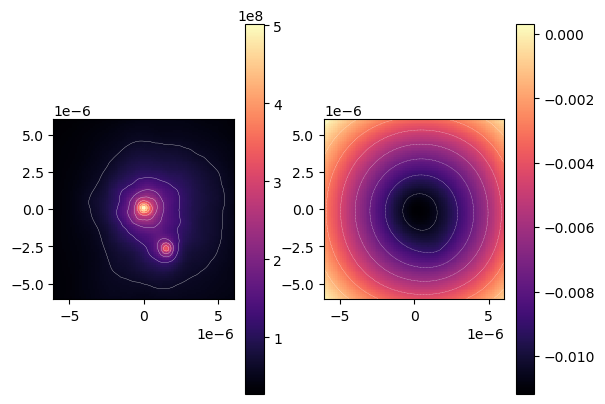

In [ ]:
plt.subplot(1, 2, 1)
i = 1

z_l = 0.4
z_s = 2

theta = X[i, :]/D_angular(z_l)
Epsilon_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))
plt.pcolormesh(theta, theta, galaxies[i, :, :], cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, galaxies[i, :, :], colors = 'white', linewidths = 0.2)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), colors = 'white', linewidths = 0.2)
plt.gca().set_aspect('equal')


4.78663516644209e-17